# Getting started

This tutorial covers the basics of computing 2D GPs with ``exoplanet`` using the classes provided by ``specgp``. For a more complete tutorial on using ``celerite`` in ``exoplanet``, check out the [exoplanet docs](https://docs.exoplanet.codes/en/stable/). If you're not familiar with ``exoplanet``, it might be helpful to take a look at some of those tutorials before working through these. 

``exoplanet`` and ``specgp`` are primarily intended for use with ``pymc3``. For this reason all variables used by ``specgp`` are stored as nodes in a computational graph in the form of ``theano`` tensors. This means that in order to compute the actual value of a variable outside of the ``pymc3`` model context, we'll need to periodically call ``.eval()`` to get the actual values of these nodes.

To start, let's define a 1D ``celerite`` term:

In [1]:
import numpy as np
import exoplanet as xo

term = xo.gp.terms.SHOTerm(log_S0=0.0, log_w0=1.0, log_Q=-np.log(np.sqrt(2)))

Here we've chosen the simple harmonic oscillator (SHO) term, which is a commonly used model for stellar variability. The choice is somewhat arbitrary; ``specgp`` works with any ``celerite`` term.

If we're only working in one dimension we can define the GP with this kernel alone. Here ``diag`` is the white noise *variance* for the GP and ``J`` is the width of the system (each ``SHOTerm`` contributes J=2 to the total width).

In [2]:
t = np.linspace(0, 10, 1000)
gp = xo.gp.GP(
                x=t, 
                kernel=term, 
                diag=0.01 * np.ones_like(t), 
                mean=xo.gp.means.Constant(0.0), 
                J=2
              )

Let's take a look at a random realization of this GP:

Text(0, 0.5, 'y')

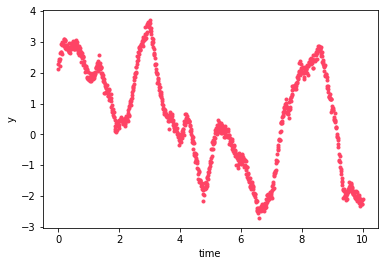

In [3]:
import matplotlib.pyplot as pl
%matplotlib inline

n = np.random.randn(len(t), 1)
y = gp.dot_l(n).eval()

pl.plot(t, y, '.', color='#FE4365')
pl.xlabel("time")
pl.ylabel("y")

What if we want to model two timeseries that have the same underlaying variability? This is where ``specgp`` comes in. It provides a class, ``KronTerm`` that defines a Kronecker-structured covariance matrix for computing a 2D GP (which can also be thought of as a collection of correlated 1D GPs). 

In [11]:
import specgp as sgp

# scaling factor for each process
alpha = [1, 2]
kernel = sgp.terms.KronTerm(term, alpha=alpha)

For the 2D GP, both ``diag`` (the white noise variances for each input coordinate) and ``mean`` (the value of the GP mean for each input coordinate) are two dimensional:

In [5]:
# the white noise components for each process
# here we set the second process to have 100 times the white noise 
# variance of the first.
diag = np.array([0.001, 0.1])
diag = diag[:, None] * np.ones_like(t)
print(diag)

[[0.001 0.001 0.001 ... 0.001 0.001 0.001]
 [0.1   0.1   0.1   ... 0.1   0.1   0.1  ]]


For the the GP mean we need to use the provided ``KronMean`` mean function which is compatible with the ``KronTerm`` kernel. ``KronMean`` defines a constant mean function. We give it two values, each being the (constant) mean of one of the processes:

In [6]:
mu = sgp.means.KronMean(np.zeros((2, len(t))))

Finally, we can define the 2D GP:

In [7]:
gp = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=mu, J=2)

Let's take a look at a realization of this GP:

Text(0, 0.5, 'y')

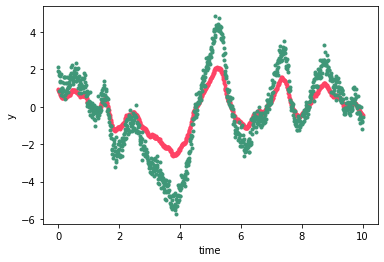

In [8]:
n = np.random.randn(2*len(t), 1)
y = gp.dot_l(n).eval()

pl.plot(t, y[::2], '.', color='#FE4365')
pl.plot(t, y[1::2], '.', color='#3F9778')
pl.xlabel("time")
pl.ylabel("y")

A quick note on the structure of the vector returned by ``dot_l``: ``y`` is a 1D vector with the first 2 elements consisting of the first observation for each of the two processes, the next two being the second observation at each wavelength, and so forth. We could also write $y = vec(Y)$ where $Y$ is a matrix of size $2\times N$ with $N$ the number of times and with each of the rows containing the timeseries of one of the correlated processes. For $M$ correlated processes the first $M$ elements of $y$ are the observation at the first time for each process, and so forth:  

In [9]:
nprocesses = 10

alpha = np.linspace(1, 10, nprocesses)
kernel = sgp.terms.KronTerm(term, alpha=alpha)

diag = np.array([0.01] * nprocesses)
diag = diag[:, None] * np.ones_like(t)

mu = sgp.means.KronMean(np.zeros((2, len(t))))
gp = xo.gp.GP(x=t, kernel=kernel, diag=diag, mean=mu, J=2)

n = np.random.randn(nprocesses*len(t), 1)
y = gp.dot_l(n).eval()

Text(0, 0.5, 'y')

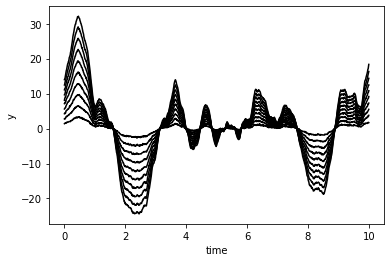

In [10]:
for i in range(nprocesses):
    pl.plot(t, y[i::nprocesses], '-', color='k')
pl.xlabel("time")
pl.ylabel("y")